In [5]:
import numpy as np

import torch 
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc 

In [6]:
import datetime 
from torch.utils.tensorboard import SummaryWriter
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn 
        self.optimizer = optimizer 
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        self.train_loader = None 
        self.val_loader = None 
        self.writer = None 

        self.losses = []
        self.val_losses = []
        self.total_epoches = 0

        self.train_step_fn = self._make_train_step_fn
        self.val_step_fn = self._make_val_step_fn 

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
    def set_tensorboard(self, name, folder='runs'):
        suffix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    # def to(self, device):
    #     pass

    def _make_train_step_fn(self):
        def perform_train_step_fn(x,y):
            # set model to TRAIN mode
            self.model.train()
            # step1 - computes predictions
            yhat = self.model(x)
            # step2 - computes loss
            loss = self.loss_fn(yhat,y)
            # step3 - computes gradients
            loss.backward()
            # step4 - updates parameters
            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        def perform_val_step_fn(x,y):
            # set model to EVAL mode
            self.model.eval()
            # step1 - computes predictions
            yhat = self.model(x)
            # step2 - computes loss
            loss = self.loss_fn(yhat, y)

            return loss.item()
        return perform_val_step_fn
    

def _mini_batch(self, validation=False):
    if validation:
        data_loader = self.val_loader 
        step_fn = self.val_step_fn 
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)
        mini_batch_loss = step_fn(x_batch,y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss 
    
setattr(StepByStep, '_mini_batch', _mini_batch)

def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    torch.manual_seed(seed)
    np.random.seed(seed)

setattr(StepByStep, 'set_seed', set_seed)

def train(self, n_epochs, seed=42):
    self.set_seed(seed)

    for epoch in range(n_epochs):
        self.total_epochs += 1
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        with torch.no_grad():
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation':val_loss})
            self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)

    if self.writer:
        self.writer.flush()

setattr(StepByStep, 'train', train)

def save_checkpoint(self, filename):
    checkpoint = {
        'epoch': self.total_epoch,
        'model_state_dict': self.model_state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'loss': self.losses,
        'val_loss': self.val_losses
    }
    torch.save(checkpoint, filename)

setattr(StepByStep, 'save_checkpoint', save_checkpoint)

def load_checkpoint(self, filename):
    checkpoint = torch.load(filename)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']
    self.model.train()

setattr(StepByStep, 'load_checkpoint', load_checkpoint)

def predict(self, x):
    self.model.eval()
    x_tensor = torch.as_tensor(x).float()
    y_hat_tensor = self.model(x_tensor.to(self.device))
    self.model.train()
    return y_hat_tensor.detach().cpu().numpy()

setattr(StepByStep, 'predict', predict)

In [7]:
X,y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=13)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

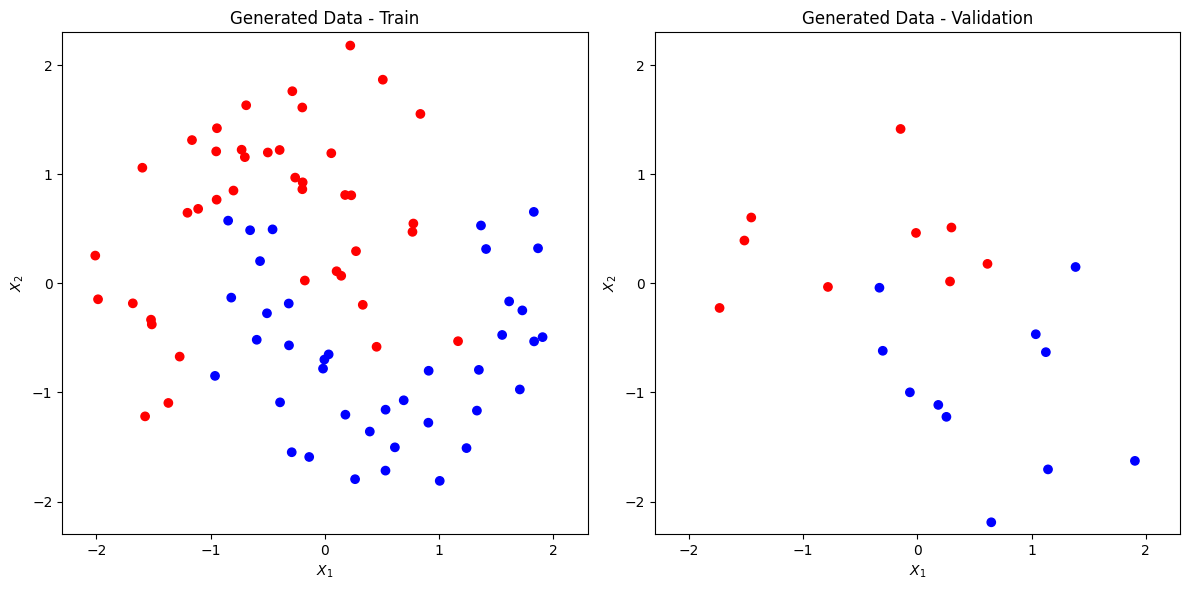

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def figure1(X_train, y_train, X_val, y_val, cm_bright=None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)#, edgecolors='k')
    ax[0].set_xlabel(r'$X_1$')
    ax[0].set_ylabel(r'$X_2$')
    ax[0].set_xlim([-2.3, 2.3])
    ax[0].set_ylim([-2.3, 2.3])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright)#, edgecolors='k')
    ax[1].set_xlabel(r'$X_1$')
    ax[1].set_ylabel(r'$X_2$')
    ax[1].set_xlim([-2.3, 2.3])
    ax[1].set_ylim([-2.3, 2.3])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()
    
    return fig

fig = figure1(X_train,y_train,X_val,y_val)